# Modèles de Deep Learning appliqués au texte

In [2]:
import h5py
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, SimpleRNN
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils.data_utils import pad_sequences
import datetime

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow_addons as tfa # deprecated (see warning below), but cannot use F1Score from tensorflow.keras.metrics 
# because it is only available in newest versions of tensorflow, which are not usable as for now (may 2024) on Mac computers. 



In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Préparation des données et création du tokenizer et des callbacks

In [5]:
# Loading the 2 CSVs
X = pd.read_csv( 'X_train.csv', delimiter=',', index_col=0)
y = pd.read_csv( 'Y_train.csv', delimiter=',', index_col=0)

In [6]:
# On met de côté un jeu de test auquel on ne touchera pas jusqu'à la fin, au moment de mesurer la performance du modèle retenu
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Nombre total de catégories
num_categories = len(label_encoder.classes_)

# Convertir en représentation one-hot
y_one_hot = to_categorical(y_encoded, num_categories)


In [8]:
X_train_txt, X_val_txt, y_train, y_val = train_test_split(X, y_one_hot, 
                                                          test_size=0.2, 
                                                          random_state=0, 
                                                          stratify=y)


In [9]:
n_class = 27
max_words = 10000
max_len = 34          # correspond au nombre de mots maximum du jeu de données

In [10]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train_txt['designation'])
sequences = tok.texts_to_sequences(X_train_txt['designation'])
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

import pickle
# Sauvegarder le tokenizer avec pickle
with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tok, f)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping( patience=2, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

# Learning rate
reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

# checkpoints
checkpoint_dir = "checkpoint/checkpoint_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint = ModelCheckpoint(filepath=checkpoint_dir, 
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             save_freq='epoch')

# Tensorboard
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# on compile nos callbacks
callbacks_list = [early_stopping, reduce_learning_rate]


## Modélisation avec LSTM

In [22]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(256,activation="relu",kernel_initializer="he_normal", kernel_regularizer=l2(0.02)))
model.add(Dropout(0.6))
model.add(Dense(27,activation="softmax"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 27)                6939      
                                                                 
Total params: 1,352,987
Trainable params: 1,352,987
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=n_class, average="weighted"), "accuracy"])


In [24]:
model.fit(sequences_matrix,
         y_train,
         batch_size=32,
         epochs=50,
         validation_split=0.2, 
         callbacks=callbacks_list)

# Le chemin vers la sauvegarde du réseau
model_savepath  = '../models/LSTM.h5'

# Sauvegarde du réseau après entrainement
model.save(model_savepath)


Epoch 1/50
1359/1359 [==============================] - 17s 12ms/step - loss: 2.4973 - f1_score: 0.5154 - accuracy: 0.5442 - val_loss: 1.1275 - val_f1_score: 0.6869 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 2/50
1359/1359 [==============================] - 17s 12ms/step - loss: 0.9544 - f1_score: 0.7511 - accuracy: 0.7574 - val_loss: 0.9775 - val_f1_score: 0.7385 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 3/50
1359/1359 [==============================] - 17s 12ms/step - loss: 0.7441 - f1_score: 0.8131 - accuracy: 0.8167 - val_loss: 0.9505 - val_f1_score: 0.7557 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 4/50
1359/1359 [==============================] - 16s 12ms/step - loss: 0.6153 - f1_score: 0.8512 - accuracy: 0.8528 - val_loss: 0.9643 - val_f1_score: 0.7623 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 5/50
1359/1359 [==============================] - 16s 12ms/step - loss: 0.5261 - f1_score: 0.8756 - accuracy: 0.8764 - val_loss: 0.9953 - val_f1_score: 0.7668 - val_accuracy: 0.7672 - lr: 0.

In [12]:
test_sequences = tok.texts_to_sequences(X_val_txt['designation'])
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)


In [27]:
accr = model.evaluate(test_sequences_matrix, y_val)

425/425 [==============================] - 2s 4ms/step - loss: 0.9945 - f1_score: 0.7661 - accuracy: 0.7666


In [14]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('../models/LSTM.h5')

y_pred = np.argmax(model.predict(test_sequences_matrix), axis = -1)
y_true = np.argmax(y_val, axis = -1)

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

425/425 [==============================] - 3s 2ms/step


In [15]:
from sklearn.metrics import classification_report

report = classification_report(np.array(y_true), np.array(y_pred), target_names=list(map(str,label_encoder.classes_)))
print(report)


              precision    recall  f1-score   support

          10       0.51      0.39      0.44       499
          40       0.63      0.57      0.60       401
          50       0.68      0.68      0.68       269
          60       0.84      0.72      0.78       133
        1140       0.66      0.72      0.69       427
        1160       0.91      0.85      0.88       632
        1180       0.36      0.48      0.41       122
        1280       0.65      0.67      0.66       779
        1281       0.44      0.37      0.40       331
        1300       0.97      0.91      0.94       807
        1301       0.95      0.87      0.91       129
        1302       0.79      0.78      0.79       399
        1320       0.67      0.69      0.68       519
        1560       0.78      0.83      0.81       812
        1920       0.86      0.89      0.87       689
        1940       0.70      0.77      0.74       128
        2060       0.75      0.77      0.76       799
        2220       0.72    

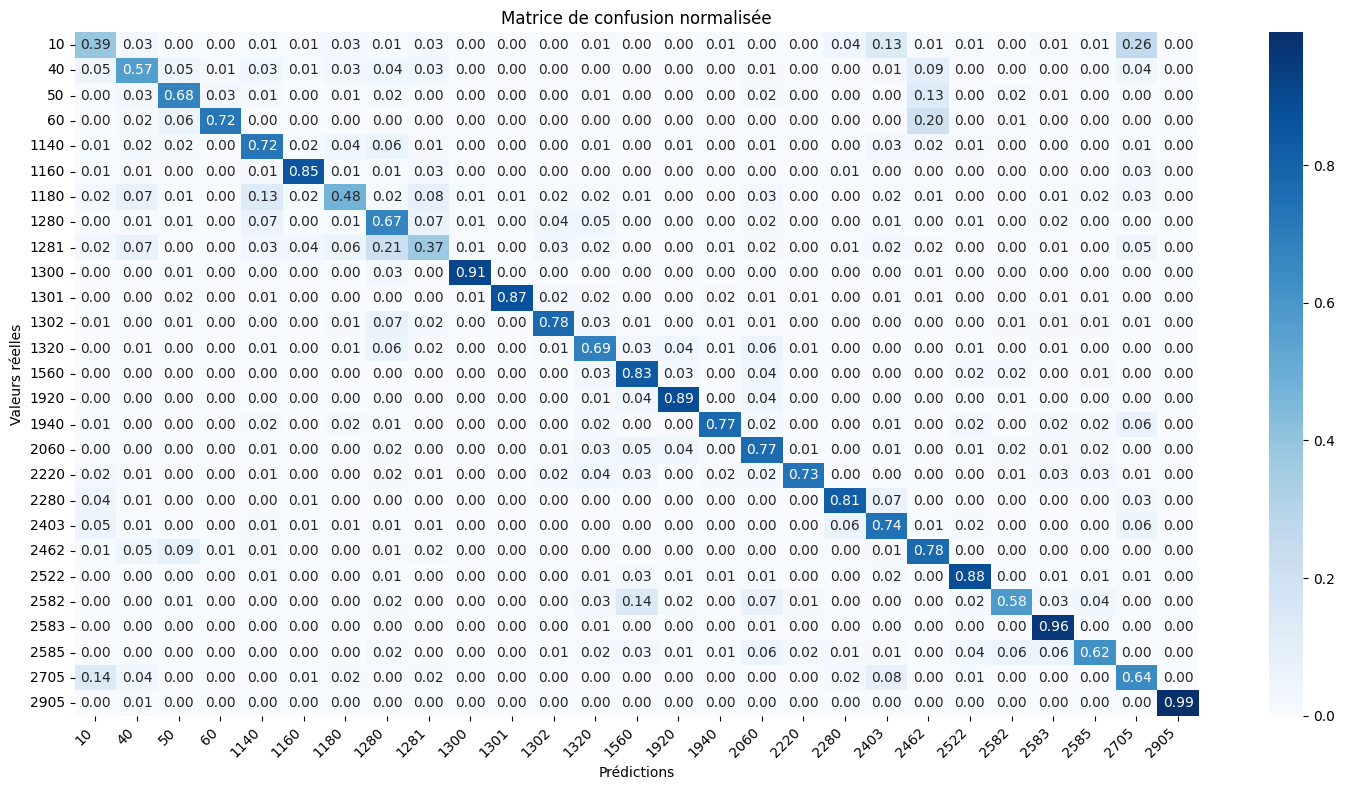

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Matrice de confusion normalisée')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# Rotation des étiquettes des axes pour éviter les chevauchements
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Ajustement de l'espacement pour que tout soit bien visible
plt.tight_layout()

plt.show()

## Modélisation avec un CNN (reproduction du modèle Benchmark)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv2D, MaxPooling2D, Concatenate, Flatten, Dropout, Dense, Reshape

# Définition de la longueur maximale du texte
max_length = max_len

# Nombre total de mots dans le vocabulaire (exemple)
vocab_size = 10000

# Dimension de l'embedding
embedding_dim = 300

# Nombre de filtres pour chaque convolution
num_filters = 512

# Taille des filtres pour chaque convolution
filter_sizes = [1, 2, 3, 4, 5, 6]

# Input layer
inputs = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Reshape layer pour adapter aux convolutions
reshape_layer = Reshape((max_length, embedding_dim, 1))(embedding_layer)

conv_blocks = []
for filter_size in filter_sizes:
    # Convolutional layer
    conv_layer = Conv2D(filters=num_filters,
                        kernel_size=(filter_size, embedding_dim),
                        padding='valid',
                        activation='relu')(reshape_layer)
    # Max pooling layer
    max_pooling_layer = MaxPooling2D(pool_size=(max_length - filter_size + 1, 1),
                                      padding='valid')(conv_layer)
    conv_blocks.append(max_pooling_layer)

# Concaténation des max pooling layers
concatenated = Concatenate()(conv_blocks)
flatten_layer = Flatten()(concatenated)

# Dropout layer
dropout_layer = Dropout(0.5)(flatten_layer)

# Fully connected layer
outputs = Dense(27, activation='softmax')(dropout_layer)

# Création du modèle
model = Model(inputs=inputs, outputs=outputs)

# Résumé du modèle
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 34, 300)      3000000     ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 34, 300, 1)   0           ['embedding_4[0][0]']            
                                                                                                  
 conv2d_12 (Conv2D)             (None, 34, 1, 512)   154112      ['reshape_2[0][0]']              
                                                                                            

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=n_class, average="weighted"), "accuracy"]
              )


In [33]:
model.fit(sequences_matrix,
         y_train,
         batch_size=32,
         epochs=50,
         validation_split=0.2, 
         callbacks=callbacks_list)

# Le chemin vers la sauvegarde du réseau
model_savepath  = '../models/cnn_text.h5'

# Sauvegarde du réseau après entrainement
model.save(model_savepath)


Epoch 1/50
1359/1359 [==============================] - 961s 697ms/step - loss: 0.9837 - f1_score: 0.7158 - accuracy: 0.7194 - val_loss: 0.7426 - val_f1_score: 0.7913 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 2/50
1359/1359 [==============================] - 930s 685ms/step - loss: 0.4738 - f1_score: 0.8575 - accuracy: 0.8575 - val_loss: 0.8159 - val_f1_score: 0.7921 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/50
1359/1359 [==============================] - 922s 679ms/step - loss: 0.2853 - f1_score: 0.9136 - accuracy: 0.9134 - val_loss: 1.0471 - val_f1_score: 0.7830 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 3: early stopping


In [36]:
test_sequences = tok.texts_to_sequences(X_val_txt['designation'])
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix, y_val)


425/425 [==============================] - 3s 6ms/step - loss: 0.9484 - f1_score: 0.7887 - accuracy: 0.7894


In [17]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('../models/cnn_text.h5')


y_pred = np.argmax(model.predict(test_sequences_matrix), axis = -1)
y_true = np.argmax(y_val, axis = -1)

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

425/425 [==============================] - 3s 3ms/step


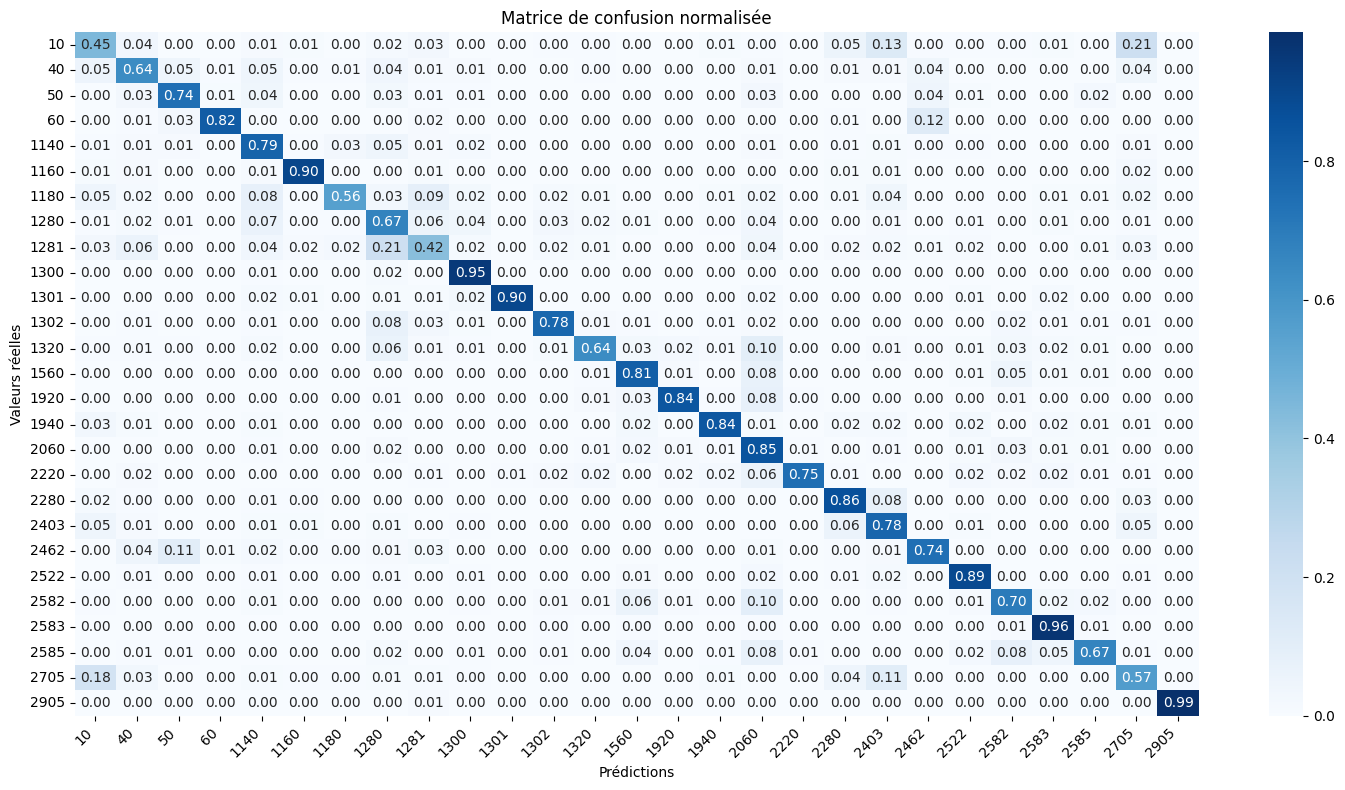

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Matrice de confusion normalisée')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# Rotation des étiquettes des axes pour éviter les chevauchements
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Ajustement de l'espacement pour que tout soit bien visible
plt.tight_layout()

plt.show()

In [19]:
from sklearn.metrics import classification_report

report = classification_report(np.array(y_true), np.array(y_pred), target_names=list(map(str,label_encoder.classes_)))
print(report)


              precision    recall  f1-score   support

          10       0.53      0.45      0.49       499
          40       0.66      0.64      0.65       401
          50       0.75      0.74      0.75       269
          60       0.92      0.82      0.87       133
        1140       0.66      0.79      0.72       427
        1160       0.94      0.90      0.92       632
        1180       0.66      0.56      0.60       122
        1280       0.68      0.67      0.67       779
        1281       0.51      0.42      0.46       331
        1300       0.90      0.95      0.92       807
        1301       0.99      0.90      0.94       129
        1302       0.83      0.78      0.80       399
        1320       0.84      0.64      0.73       519
        1560       0.84      0.81      0.82       812
        1920       0.93      0.84      0.88       689
        1940       0.70      0.84      0.76       128
        2060       0.66      0.85      0.74       799
        2220       0.90    